In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Purpose of this file is to perform further EDA using our principal components, to observe whether any patterns or structure exists within our data

In [2]:
df = pd.read_csv("./Data/PCAData.csv")
df.head()

,PC1,PC2,PC3,PC4,PC5,Player,Team
0,-7.989976,7.172228,-3.494397,-2.383515,-1.511902,Stephen Curry,GSW
1,-4.275016,7.960160,-2.488428,-4.343693,-1.695037,Bradley Beal,WAS
2,-9.065379,8.188754,-0.748121,-4.408168,1.040886,Damian Lillard,POR
3,6.894107,15.573695,-3.977882,2.099893,6.357913,Joel Embiid,PHI
4,0.724766,12.020710,2.112283,-1.421188,0.619788,Giannis Antetokounmpo,MIL


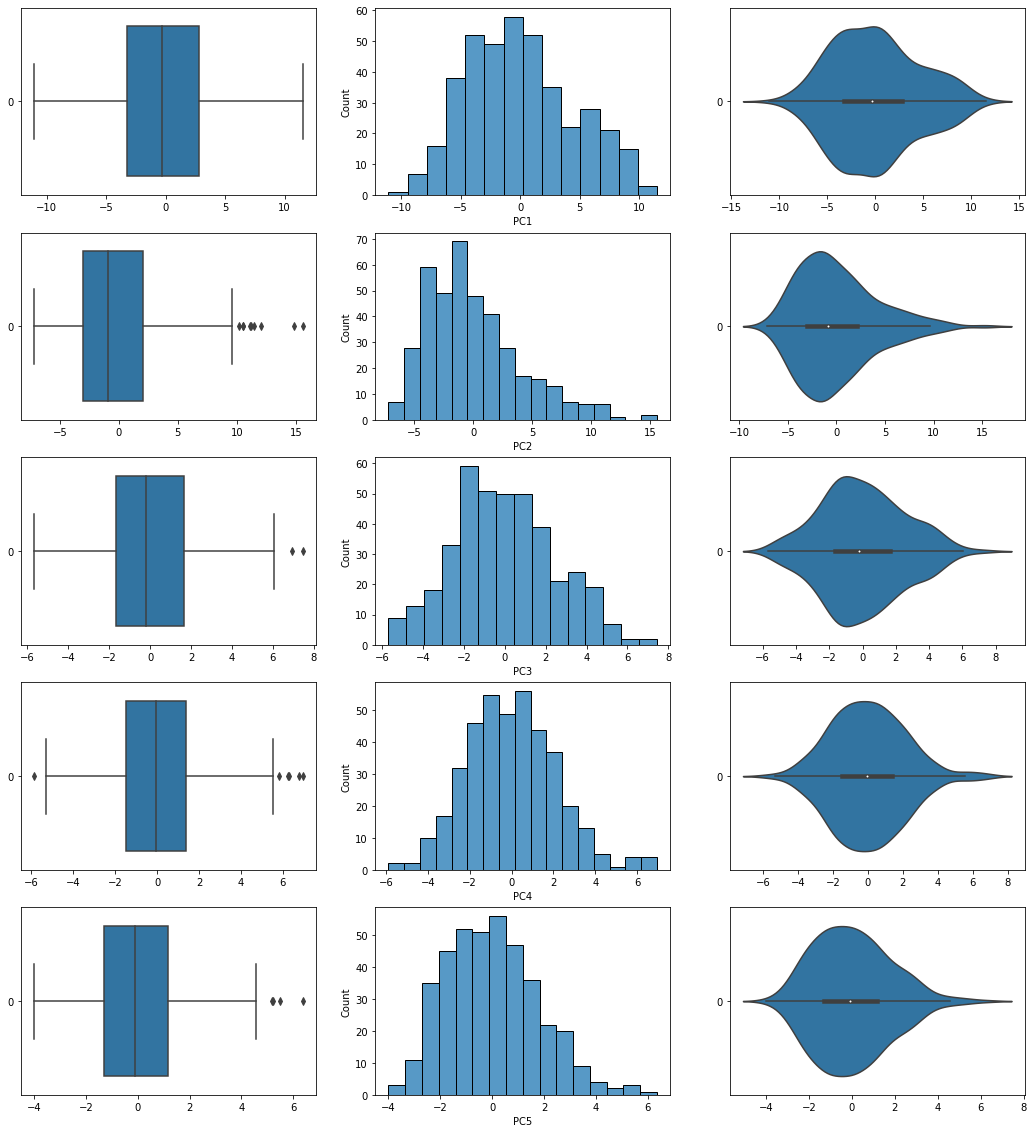

In [3]:
# Draw the distributions of all variables
f, axes = plt.subplots(5, 3, figsize=(18, 20))

for i in range (1, 6):
    sns.boxplot(data = df[f"PC{i}"], orient = "h", ax = axes[i - 1, 0])
    sns.histplot(data = df[f"PC{i}"], ax = axes[i - 1, 1])
    sns.violinplot(data = df[f"PC{i}"], orient = "h", ax = axes[i - 1, 2])